<a href="https://colab.research.google.com/github/syedsauda/CE888/blob/master/Assignment2/Assignment2_dataset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download and install scikit plot

In [31]:
pip install scikit-plot

#Importing Libraries and Functions

In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import cross_val_score

from zipfile import ZipFile

#Load dataset into pandas dataframe

In [33]:
dataset_link = "https://raw.githubusercontent.com/syedsauda/CE888/master/Assignment2/train.csv"
orig_df_train = pd.read_csv(dataset_link, header=0, sep=',', quotechar='"')
#orig_df_test = pd.read_csv('test.csv', header=0, sep=',', quotechar='"')

print(orig_df_train)
#print(orig_df_test.head())

     age  sex  cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0     63    1   3       145   233    1  ...      0      2.3      0   0     1       1
1     37    1   2       130   250    0  ...      0      3.5      0   0     2       1
2     41    0   1       130   204    0  ...      0      1.4      2   0     2       1
3     56    1   1       120   236    0  ...      0      0.8      2   0     2       1
4     57    0   0       120   354    0  ...      1      0.6      2   0     2       1
..   ...  ...  ..       ...   ...  ...  ...    ...      ...    ...  ..   ...     ...
298   57    0   0       140   241    0  ...      1      0.2      1   0     3       0
299   45    1   3       110   264    0  ...      0      1.2      1   0     3       0
300   68    1   0       144   193    1  ...      0      3.4      1   2     3       0
301   57    1   0       130   131    0  ...      1      1.2      1   1     3       0
302   57    0   1       130   236    0  ...      0      0.0      

In [115]:
age = 60
print(orig_df_train.where(orig_df_train["age"]>age).dropna().shape)
print(orig_df_train.where(orig_df_train["age"]<=age).dropna().shape)
print(orig_df_train.where(orig_df_train["sex"]==1).dropna().shape)
print(orig_df_train.where(orig_df_train["sex"]==0).dropna().shape)

(79, 14)
(224, 14)
(207, 14)
(96, 14)


Identifying the target variable and the ID varaiable

In [0]:
target_var = "target"

#Detecting Covariate shift in data

Removing un-important columns (id) and output/target column(price_doc)

In [0]:
df_train = orig_df_train.where(orig_df_train["sex"]==1).dropna().drop(columns=[target_var])
df_test = orig_df_train.where(orig_df_train["sex"]==0).dropna().drop(columns=[target_var])

In [37]:
print(df_train.shape)
print(df_test.shape)

(207, 13)
(96, 13)


Adding is_test column

In [0]:
df_train['is_test'] = 0
df_test['is_test'] = 1

combine dataset

In [39]:
df = pd.concat([df_train, df_test], axis = 0)
df.shape

(303, 14)

Function to split and clasiify and show roc and auc score

In [0]:
def split_and_classify(df, feature):
  #Removing column to classify (TARGET)
  X = df.drop(columns=[feature]) 
  y = df[feature]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True) #Randomising nad splitting before classification
  
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_test_score = rfc.predict_proba(X_test)
  skplt.metrics.plot_roc(y_test, y_test_score)
  plt.show()
  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))
  return X,y;

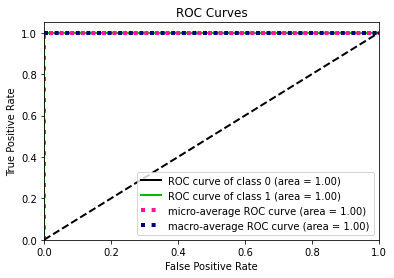

AUC score:  1.0


In [41]:
X,y = split_and_classify(df,"is_test")

Finding features causing covariate shift

In [42]:
drop_list = []
model = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5)
for i in X.columns:
    score = cross_val_score(model,pd.DataFrame(X[i]),y,cv=2,scoring='roc_auc')
    if (np.mean(score) > 0.8):
        drop_list.append(i)
        print(i,np.mean(score))

sex 1.0


In [43]:
print(drop_list)

['sex']


Removing features that cause shift

In [44]:
df.drop(columns=drop_list,inplace=True)
df.shape

(303, 13)

In [0]:
def histo(df_test, df_train, feature):
  print("Histogram of dataset on '",feature,"'")
  histo = sns.distplot(df_test[[feature]].values.T[0], color="blue", kde=False, label="Testing data")
  histo = sns.distplot(df_train[[feature]].values.T[0], color="red", kde=False, label="Training data")
  legend = histo.legend()

In [0]:
normalized_test=(df_test-orig_df_train.min())/(orig_df_train.max()-orig_df_train.min())
normalized_train=(df_train-orig_df_train.min())/(orig_df_train.max()-orig_df_train.min())

Histogram of dataset on ' sex '


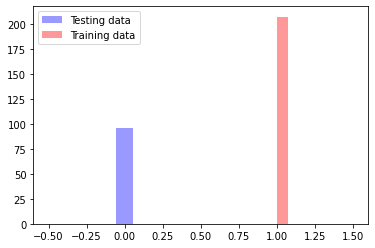

In [47]:
histo(df_test, df_train,drop_list[0])

splitting and classifying with removed features

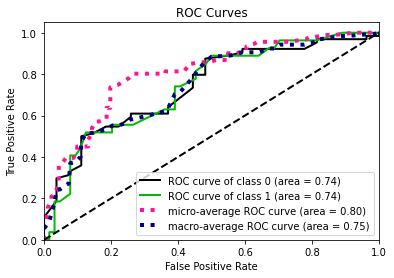

AUC score:  0.7416


In [48]:
unused,unused2 = split_and_classify(df,"is_test")

TRAINING TARGET VARIABLE

In [0]:
def classify_rfc(train_df, test_df, feature):

  X_train = train_df.drop(columns=[feature])
  y_train = train_df[feature]

  X_test = test_df.drop(columns=[feature])
  y_test = test_df[feature]
  
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_test_score = rfc.predict_proba(X_test)
  skplt.metrics.plot_roc(y_test, y_test_score)
  plt.show()
  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))

 with co-variate shift

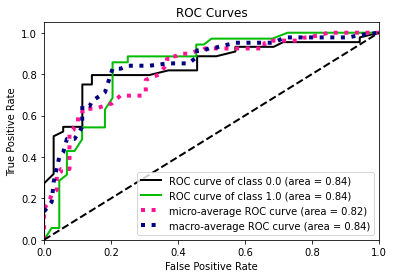

AUC score:  0.8383


In [141]:
df_train = orig_df_train.where(orig_df_train["age"]<=60).dropna().drop(columns=[])
df_test = orig_df_train.where(orig_df_train["age"]>60).dropna().drop(columns=[])
classify_rfc(df_train,df_test,"target")

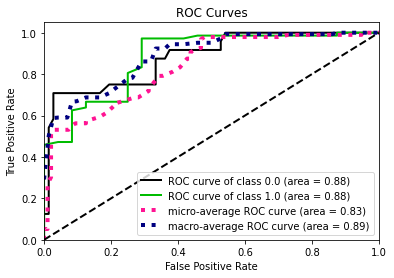

AUC score:  0.8811


In [139]:
df_train = orig_df_train.where(orig_df_train["sex"]==1).dropna().drop(columns=[])
df_test = orig_df_train.where(orig_df_train["sex"]==0).dropna().drop(columns=[])
classify_rfc(df_train,df_test,"target")

without co-variate shift

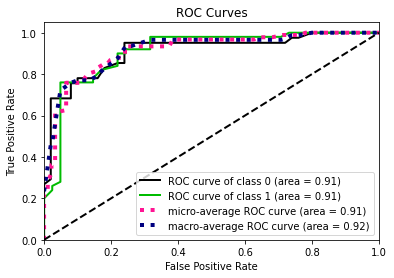

AUC score:  0.9102


In [135]:
unused,unused2 = split_and_classify(orig_df_train,"target")

WITH SEX COLUMN REMOVED

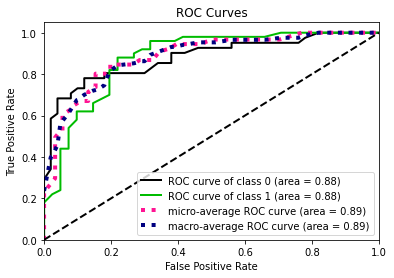

AUC score:  0.8798


In [133]:
unused,unused2 = split_and_classify(orig_df_train.drop(columns=["sex"]),"target")